In [ ]:
!pip install -q transformers datasets torchsummary

     |████████████████████████████████| 2.6 MB 7.5 MB/s 
     |████████████████████████████████| 542 kB 60.0 MB/s 
     |████████████████████████████████| 3.3 MB 62.0 MB/s 
     |████████████████████████████████| 895 kB 58.5 MB/s 
     |████████████████████████████████| 636 kB 51.8 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
     |████████████████████████████████| 243 kB 63.5 MB/s 
     |████████████████████████████████| 118 kB 40.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import datetime
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
from datasets import load_dataset, list_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
train_ds, test_ds = load_dataset("tweets_hate_speech_detection", split=['train[:80%]', 'train[-20%:]'])
train_ds, test_ds 

Downloading:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/881 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset tweets_hate_speech_detection downloaded and prepared to /root/.cache/huggingface/datasets/tweets_hate_speech_detection/default/0.0.0/3e953745870454cf8ff15cc48097dbb5ff459596e0a089867c2a29cee63984ec. Subsequent calls will reuse this data.


(Dataset({
     features: ['label', 'tweet'],
     num_rows: 25570
 }), Dataset({
     features: ['label', 'tweet'],
     num_rows: 6392
 }))

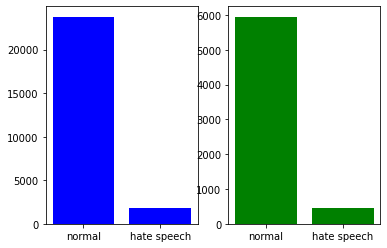

In [ ]:
labels_train = train_ds['label']
labels_test = test_ds['label']

hate_labels_train = sum(labels_train)
not_hate_labels_train = len(labels_train) - sum(labels_train)

hate_labels_test = sum(labels_test)
not_hate_labels_test = len(labels_test) - sum(labels_test)


fig, (ax1,ax2) = plt.subplots(1,2)
_ = ax1.bar(x=["normal", "hate speech"], height = [not_hate_labels_train, hate_labels_train], color='b' )
_ = ax2.bar(x=["normal", "hate speech"], height = [not_hate_labels_test, hate_labels_test], color='g' )

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
tokenize_func = lambda sentences: tokenizer(sentences['tweet'], padding="max_length", truncation=True)

tok_train_ds = train_ds.map(tokenize_func, batched=True)
tok_test_ds = test_ds.map(tokenize_func, batched=True)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
not_hate_labels_test/(not_hate_labels_test+hate_labels_test)

0.9306946182728411

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2)

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 

In [ ]:

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=tok_train_ds, eval_dataset=tok_test_ds, compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tweet.
***** Running training *****
  Num examples = 25570
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7995


Step,Training Loss
10,0.640600
20,0.616900
30,0.591300
40,0.509100
50,0.420300
60,0.280400
70,0.306800
80,0.226600
90,0.214300
100,0.277000


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/config.json
Model weights saved in ./results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2500
Configuration saved in ./results/checkpoint-2500/config.json
Model weights saved in ./results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-3000
Configuration saved in ./results/checkpoint-3

TrainOutput(global_step=7995, training_loss=0.06142627586647163, metrics={'train_runtime': 6173.8032, 'train_samples_per_second': 20.708, 'train_steps_per_second': 1.295, 'total_flos': 1.69359569181696e+16, 'train_loss': 0.06142627586647163, 'epoch': 5.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: tweet.
***** Running Evaluation *****
  Num examples = 6392
  Batch size = 16


{'epoch': 5.0,
 'eval_accuracy': 0.9816958698372966,
 'eval_f1': 0.8612099644128114,
 'eval_loss': 0.12132309377193451,
 'eval_precision': 0.9075,
 'eval_recall': 0.8194130925507901,
 'eval_runtime': 100.8981,
 'eval_samples_per_second': 63.351,
 'eval_steps_per_second': 3.964}

In [ ]:
model.save_pretrained("/content/drive/MyDrive/ROBERTA_hate_speech")

Configuration saved in /content/drive/MyDrive/ROBERTA_hate_speech/config.json
Model weights saved in /content/drive/MyDrive/ROBERTA_hate_speech/pytorch_model.bin
